# Introductory Material

Imports and utility functions

In [ ]:
import pandas as pd 
from util_modeling import *
import pickle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np

In [ ]:
def load_obj(name, transactions_dir = '/data/gentrification/celltransactions/'):
    with open(transactions_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def geopandas_formulation(df):
    global parks_df
    locations_sbls = new_df['Location'].apply(lambda x: [ float(n.replace('(','').replace(')','')) 
                                                         for n in x.split(',')] 
                                              if x == x else np.nan)
    gdf = gpd.GeoDataFrame(new_df, 
                           geometry=gpd.points_from_xy(locations_sbls.apply(lambda x: x[1]), 
                                                       locations_sbls.apply(lambda y: y[0])))
    gdf.crs = {'init' :'epsg:4326'}
    parks_df = parks_df.to_crs(epsg=3857)
    gdf = gdf.to_crs(parks_df.crs)
    gdf['Actual Date'] = pd.to_datetime(gdf['Actual Date'])
    gdf['year'] = gdf['Actual Date'].apply(lambda x: x.year)
    gdf['month'] = gdf['Actual Date'].apply(lambda x: x.month)
    gdf['consideration'] = gdf['consideration'].str.replace('$','').str.replace(',','').astype(float)
    gdf = gdf[gdf['consideration'] > 5]
    years_list = {}
    months_list = {}
    for name,grp in gdf.groupby('year'):
        years_list[name] = grp.drop_duplicates(subset=['sbl']) 
    for name, grp in gdf.groupby(['year','month']):
        months_list[name] = grp.drop_duplicates(subset = ['sbl'])
    return gdf, years_list, months_list

def cell_formation(gdf_unique_houses, n_cells):
    global x_range 
    global y_range 
    global matrix_cells 
    global cell 
    xmin, ymin, xmax, ymax= gdf_unique_houses.total_bounds
    # how many cells across and down
    n_cells=n_cells
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    x_range = np.arange(xmin, xmax+cell_size, cell_size )
    y_range = np.arange(ymin, ymax+cell_size, cell_size)
    indexes = []
    matrix_cells = Matrix = [[0 for x in range(len(x_range))] for y in range(len(y_range))] 
    matrix_binomial = [[[] for x in range(len(x_range))] for y in range(len(y_range))] 
    grid_cells = []

    for xidx,x0 in enumerate(np.arange(xmin, xmax+cell_size, cell_size )):
        yidx = len(np.arange(ymin, ymax+cell_size, cell_size)) - 1
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
            matrix_cells[yidx][xidx] = shapely.geometry.box(x0, y0, x1, y1)
            indexes.append( str(yidx) + ',' + str(xidx))
            yidx -= 1
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs, index = indexes)
    return cell, grid_cells, matrix_cells, indexes, cell_size

def turn_groups_into_columns(past_df):
        list_dfs_variables = []
        for name,df in past_df.groupby(['variable']):
            copy_df = df.drop(['variable'], axis = 1 )
            copy_df = copy_df.set_index('cell_id')
            copy_df.columns = copy_df.columns + '_type:' + name

            list_dfs_variables.append(copy_df)
        return pd.concat(list_dfs_variables, axis = 1 )
    
def calc(cell_size_string, num_cells,time_frame, 
         features_dir = '/data/gentrification/updated_new_features/'):
    
    print(cell_size_string)
    cell, grid_cells, matrix_cells, indexes, cell_size = cell_formation(gdf_unique_houses, 
                                                                        n_cells = num_cells)
    var = cell_size_string
    df = pd.read_csv(features_dir+ var + '/' +  time_frame[0] + '.csv')
    dct = load_obj(var)
    keys = dct.keys()
    set_keys = [k for k in keys if '-total_houses' in k]
    values = [dct[i] for i in set_keys]
    total_houses_df = pd.DataFrame(np.vstack([set_keys,values]),
                                   index = ['cell_id','number of houses']).T
    total_houses_df['cell_id'] = total_houses_df['cell_id'].str.split('-').map(lambda x: x[0])
    total_houses_dct = total_houses_df.set_index('cell_id').to_dict()['number of houses']
    df.rename(columns = {'Unnamed: 0': 'cell_variable'}, inplace = True)
    col = df.columns
    date_time_lags_number = 3 # this will set the number of time lags
    reversed_date_range = list(reversed(pd.interval_range(start=pd.Timestamp('1/1/2000'), 
                                                          freq = time_frame[1], 
                                                          end = pd.Timestamp('12/31/2019'))))
    lst_all_years = []
    df['cell_id'] = df['cell_variable'].str.split('_').apply(lambda x: x[0])
    df['variable'] = df['cell_variable'].str.split('_').apply(lambda x: x[1])
    for idx,date_range in enumerate(reversed_date_range):
        range_date = str(date_range)

        columns_of_value_date = col[col.map(lambda x: range_date in x)].tolist() + ['cell_id','variable']  
        subset_df = df[columns_of_value_date]
        target_subset = subset_df.loc[subset_df['variable'] == 'transactions'][
            ['cell_id','value-' + range_date]].rename(columns =
                                    {'value-' + range_date:'target:number of homes sold'})
        target_subset['time_range'] = date_range
        counter_past_years = date_time_lags_number
        target_subset = target_subset.set_index('cell_id')
        past_dates = reversed_date_range[idx+1:]
        if len(past_dates) == date_time_lags_number:
            break 
        past_dfs = []
        time_counter = 1
        for r_date in past_dates:
            str_r_date = str(r_date)
            columns_of_value_date_past = col[col.map(lambda x: str_r_date in x)].tolist() + ['cell_id','variable']  
            past_df = df[columns_of_value_date_past]
            transformed_past_df = turn_groups_into_columns(past_df)
            transformed_past_df.columns = transformed_past_df.columns.map(lambda x: x.replace(str_r_date,  str(time_counter) + ' year(s) ago'))
            past_dfs.append(transformed_past_df)

            time_counter += 1 
            if counter_past_years == 1:
                break
            counter_past_years -= 1 
        concatenated_df = pd.concat(past_dfs, axis =1)
        all_df = pd.concat([target_subset,concatenated_df], axis = 1)
        lst_all_years.append(all_df)
    df_to_model = pd.concat(lst_all_years,axis = 0)
   
    series_cell_houses = df_to_model.reset_index()['cell_id'].map(total_houses_dct)
    series_cell_houses.index = df_to_model.index
    df_to_model['total_number_of_houses'] = series_cell_houses
    df_to_model['total_number_of_houses'] = df_to_model['total_number_of_houses'].astype(int)
    return df_to_model, dct, cell, matrix_cells

# Run Prediction Experiments

In [2]:
rf_regressor = RandomForestRegressor(n_estimators=1000,
                                      max_features='auto',
                                      max_depth=15,
                                      min_samples_split=12,
                                      min_samples_leaf=5,
                                      n_jobs = 8,
                                      bootstrap=True, 
                                      random_state=0)
rf_classifier = RandomForestClassifier(n_estimators=1000,
                                      max_features='auto',
                                      max_depth=15,
                                      min_samples_split=12,
                                      min_samples_leaf=5,
                                      n_jobs = 8,
                                      bootstrap=True, 
                                      random_state=0)
def run_preds(n,year, time_range_str, train, test):
    #Overall Average
    baseline_all_prior_years_average = train.groupby("cell_id").y.mean().reset_index()
    baseline_all_prior_years_average.columns = ['cell_id','pred_all_years']
    
    baseline_all_prior_years_average_std = train.groupby("cell_id").y_std.mean().reset_index()
    baseline_all_prior_years_average_std.columns = ['cell_id','pred_all_years_std']

    # Prior Year
    prior_year_df = train[train['time_range'] == train['time_range'].unique()[0]]
    baseline_previous_year = prior_year_df[['cell_id','y','y_std']]
    baseline_previous_year.columns = ['cell_id','pred_previous_year','pred_previous_year_std']

    baseline_citywide = [prior_year_df.y.mean()]*len(test)

    cols = [(x.replace("(","")
             .replace(")","")
             .replace("[","")
             .replace("]","")
             .replace(" ","")) for x in train.columns]
    train.columns = cols
    test.columns = cols

    drop_cols = ['y','y_binary','y_std','target:numberofhomessold','cell_id',"time_range"]
    test_reg = test.drop(drop_cols,axis=1)
    train_reg = train.drop(drop_cols, axis = 1)
    rf_reg_pred = rf_regressor.fit(train_reg, train.y).predict(test_reg)
    rf_reg_std_pred = rf_regressor.fit(train_reg, train.y_std).predict(test_reg)
    rf_class_pred = rf_classifier.fit(train_reg,train.y_binary).predict_proba(test_reg)[:,1]

    results = (test.assign(pred_baseline_citywide=baseline_citywide)
     .assign(pred_rf_reg=rf_reg_pred)
     .assign(pred_rf_reg_std=rf_reg_std_pred)
     .assign(pred_rf_class= rf_class_pred)
     .merge(baseline_all_prior_years_average,how='left')
     .merge(baseline_all_prior_years_average_std,how='left')
     .merge(baseline_previous_year,how='left')
    )

    results['cell_size'] = str(n)
    results['year'] = str(year)
    results['window_size'] = time_range_str
    results.to_csv("results/res_{}_{}_{}.csv".format(n,year, time_range_str),index=False)
    

In [25]:
df = pd.read_csv('filtered_data.csv')
parks_df = gpd.read_file("./Parks/")

In [14]:
# data filteration 
df = df[df['doc type'].isin(['D1A','DEED','D1B','D1BU'])]
# remove nan 
series = df['Location'].apply(lambda x : x.split(',')[0][1:] if x == x  else np.nan).apply(lambda x: '-' in x if x == x else np.nan)
index_of_faulty_locations = df[series == True].index
new_vals = df.loc[index_of_faulty_locations]['Location'].apply(lambda x : '(' + x.split(',')[1][:-1] + ',' + x.split(',')[0][1:] + ')')
df.at[index_of_faulty_locations,'Location'] = new_vals


In [18]:
new_df = df[~df['Location'].isna()].copy() # remove NaN locations 
gdf,years_list, months_list = geopandas_formulation(new_df)
gdf_unique_houses = gdf.drop_duplicates('sbl')['geometry']

/opt/anaconda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [19]:
cell, grid_cells, matrix_cells, indexes, cell_size = cell_formation(gdf_unique_houses, n_cells = 28)

print("num of rows: " + str(len(pd.DataFrame(matrix_cells).index)))
print("num of columns: " + str(len(pd.DataFrame(matrix_cells).columns)))

num of rows: 48
num of columns: 29


In [ ]:
def binarize(y):
    return y > y.quantile(.85)

def stdize(y):
    return (y-np.mean(y))/np.std(y)

for time_frame in [('-3year','3Y'),('-year','1Y'),('-2year','2Y')]:
    print(time_frame)
    for n in range(12,52,4):
        print("CELL SIZE: {}".format(n))
        cell_size_string,num_cells = str(n) + 'x' + str(n) , n 
        df_to_model, dct, cell, mat_cells= calc(cell_size_string, num_cells,time_frame)
        df_to_model.drop(['spatial lag-order:5_1 year(s) ago_type:percentages',
                              'spatial lag-order:3_1 year(s) ago_type:percentages',
                              'spatial lag-order:1_1 year(s) ago_type:percentages',
                              'spatial lag-order:5_2 year(s) ago_type:percentages'],
                             axis = 1, inplace = True, errors = 'ignore' )

        df_to_model = df_to_model.reset_index()
        df_to_model['y'] = df_to_model['target:number of homes sold'] / df_to_model['total_number_of_houses']
        df_to_model['y_binary'] = df_to_model.groupby("time_range").y.transform(binarize)
        df_to_model['y_std'] = df_to_model.groupby("time_range").y.transform(stdize)
        df_to_model = df_to_model[df_to_model['total_number_of_houses'] > 10]
        df_to_model.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_to_model.dropna(inplace = True)


        z = []
        for i,x_m in enumerate(mat_cells):
            for j, y_m in enumerate(x_m):
                z.append([i,j] + list(y_m.bounds))
        pd.DataFrame(z, columns=['cell_x','cell_y','x0','y0','x1','y1']).to_csv("cellbounds_{}.csv".format(n),
                                                                               index=False)
        for idx,time_range in enumerate(df_to_model['time_range'].unique()):
            year = time_range.right.year
            if year == 2010:
                break
            print(time_range)
            test = df_to_model[df_to_model['time_range'] == time_range]
            train = df_to_model[df_to_model['time_range'] < time_range]
            if len(train):
                run_preds(n,year,time_frame[1],train,test)

# Generate SHAP for single model

In [6]:
time_frame = ('-year','1Y')
n = 32
cell_size_string,num_cells = str(n) + 'x' + str(n) , n 
df_to_model, dct, cell, mat_cells= calc(cell_size_string, num_cells,time_frame)
df_to_model.drop(['spatial lag-order:5_1 year(s) ago_type:percentages',
                      'spatial lag-order:3_1 year(s) ago_type:percentages',
                      'spatial lag-order:1_1 year(s) ago_type:percentages',
                      'spatial lag-order:5_2 year(s) ago_type:percentages'],
                     axis = 1, inplace = True, errors = 'ignore' )

df_to_model = df_to_model.reset_index()
df_to_model['y'] = df_to_model['target:number of homes sold'] / df_to_model['total_number_of_houses']
df_to_model = df_to_model[df_to_model['total_number_of_houses'] > 10]
df_to_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_to_model.dropna(inplace = True)
for idx,time_range in enumerate(df_to_model['time_range'].unique()):
    year = time_range.right.year
    if year == 2018:
        break
    test = df_to_model[df_to_model['time_range'] == time_range]
    train = df_to_model[df_to_model['time_range'] < time_range]
    cols = [(x.replace("(","")
         .replace(")","")
         .replace("[","")
         .replace("]","")
         .replace(" ","")) for x in train.columns]
    train.columns = cols
    test.columns = cols
    drop_cols = ['y','target:numberofhomessold','cell_id',"time_range"]
    test_reg = test.drop(drop_cols,axis=1)
    train_reg = train.drop(drop_cols, axis = 1)
rf_reg_pred = rf_regressor.fit(train_reg, train.y)

import shap
shap.initjs()
explainer = shap.TreeExplainer(rf_reg_pred)

shap_values = explainer.shap_values(train_reg,approximate=True)

32x32


In [7]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(rf_reg_pred)

In [16]:
shap_values = explainer.shap_values(train_reg,approximate=True)

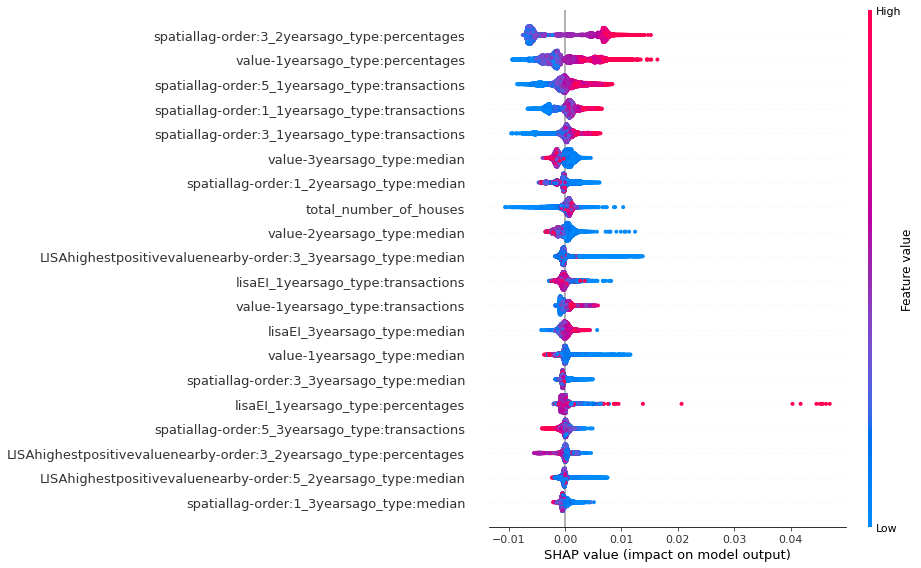

In [18]:
shap.summary_plot(shap_values, train_reg)
